In [17]:
import cv2
import numpy as np
import torch
import torchvision
import onnx
import onnxruntime as ort
import matplotlib.pyplot as plt
from glob import glob

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
def pre_process(img_resized_bchw):
    """Preprocess an image.
    Args:
        img (str or Tensor): The image to be read.
    Returns:
        Tensor: The preprocessed image.
    """
    input_img_hwc = img_resized_bchw.numpy()[0].transpose(1, 2, 0)
    img_LoadImageFromFile = input_img_hwc[:, :, [2, 1, 0]]
    # trans = get_affine_transform(np.array([144., 192.]), np.array([1.8000001, 2.3999999]), 0, np.array([288, 384]))
    trans = np.array([[0.79999993, -0., 28.80000977],
                      [0.,  0.79999996, 38.40000814]])
    img_TopDownAffine = cv2.warpAffine(
        img_LoadImageFromFile, trans, (288, 384), flags=cv2.INTER_LINEAR)
    img_ToTensor = torch.from_numpy(img_TopDownAffine.astype('float32')).permute(
        2, 0, 1).to(device).div_(255.0)
    # {'type': 'NormalizeTensor', 'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}
    img_NormalizeTensor = torchvision.transforms.functional.normalize(
        img_ToTensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]).unsqueeze(0)
    # print(img_NormalizeTensor)
    return img_NormalizeTensor

In [15]:
def post_process(res):
    def _get_max_preds(heatmaps):
        """Get keypoint predictions from score maps.

        Note:
            batch_size: N
            num_keypoints: K
            heatmap height: H
            heatmap width: W

        Args:
            heatmaps (np.ndarray[N, K, H, W]): model predicted heatmaps.

        Returns:
            tuple: A tuple containing aggregated results.

            - preds (np.ndarray[N, K, 2]): Predicted keypoint location.
            - maxvals (np.ndarray[N, K, 1]): Scores (confidence) of the keypoints.
        """
        assert isinstance(heatmaps,
                          np.ndarray), ('heatmaps should be numpy.ndarray')
        assert heatmaps.ndim == 4, 'batch_images should be 4-ndim'

        N, K, _, W = heatmaps.shape
        heatmaps_reshaped = heatmaps.reshape((N, K, -1))
        idx = np.argmax(heatmaps_reshaped, 2).reshape((N, K, 1))
        maxvals = np.amax(heatmaps_reshaped, 2).reshape((N, K, 1))

        preds = np.tile(idx, (1, 1, 2)).astype(np.float32)
        preds[:, :, 0] = preds[:, :, 0] % W
        preds[:, :, 1] = preds[:, :, 1] // W

        preds = np.where(np.tile(maxvals, (1, 1, 2)) > 0.0, preds, -1)
        return preds, maxvals

    def _gaussian_blur(heatmaps, kernel=11):
        """Modulate heatmap distribution with Gaussian.
        sigma = 0.3*((kernel_size-1)*0.5-1)+0.8
        sigma~=3 if k=17
        sigma=2 if k=11;
        sigma~=1.5 if k=7;
        sigma~=1 if k=3;

        Note:
            - batch_size: N
            - num_keypoints: K
            - heatmap height: H
            - heatmap width: W

        Args:
            heatmaps (np.ndarray[N, K, H, W]): model predicted heatmaps.
            kernel (int): Gaussian kernel size (K) for modulation, which should
                match the heatmap gaussian sigma when training.
                K=17 for sigma=3 and k=11 for sigma=2.

        Returns:
            np.ndarray ([N, K, H, W]): Modulated heatmap distribution.
        """
        assert kernel % 2 == 1

        border = (kernel - 1) // 2
        batch_size = heatmaps.shape[0]
        num_joints = heatmaps.shape[1]
        height = heatmaps.shape[2]
        width = heatmaps.shape[3]
        for i in range(batch_size):
            for j in range(num_joints):
                origin_max = np.max(heatmaps[i, j])
                dr = np.zeros((height + 2 * border, width + 2 * border),
                              dtype=np.float32)
                dr[border:-border, border:-border] = heatmaps[i, j].copy()
                dr = cv2.GaussianBlur(dr, (kernel, kernel), 0)
                heatmaps[i, j] = dr[border:-border, border:-border].copy()
                heatmaps[i, j] *= origin_max / np.max(heatmaps[i, j])
        return heatmaps

    def transform_preds(coords, center, scale, output_size, use_udp=False):
        """Get final keypoint predictions from heatmaps and apply scaling and
        translation to map them back to the image.

        Note:
            num_keypoints: K

        Args:
            coords (np.ndarray[K, ndims]):

                * If ndims=2, corrds are predicted keypoint location.
                * If ndims=4, corrds are composed of (x, y, scores, tags)
                * If ndims=5, corrds are composed of (x, y, scores, tags,
                flipped_tags)

            center (np.ndarray[2, ]): Center of the bounding box (x, y).
            scale (np.ndarray[2, ]): Scale of the bounding box
                wrt [width, height].
            output_size (np.ndarray[2, ] | list(2,)): Size of the
                destination heatmaps.
            use_udp (bool): Use unbiased data processing

        Returns:
            np.ndarray: Predicted coordinates in the images.
        """
        assert coords.shape[1] in (2, 4, 5)
        assert len(center) == 2
        assert len(scale) == 2
        assert len(output_size) == 2

        # Recover the scale which is normalized by a factor of 200.
        scale = scale * 200.0

        if use_udp:
            scale_x = scale[0] / (output_size[0] - 1.0)
            scale_y = scale[1] / (output_size[1] - 1.0)
        else:
            scale_x = scale[0] / output_size[0]
            scale_y = scale[1] / output_size[1]

        target_coords = coords.copy()
        target_coords[:, 0] = coords[:, 0] * \
            scale_x + center[0] - scale[0] * 0.5
        target_coords[:, 1] = coords[:, 1] * \
            scale_y + center[1] - scale[1] * 0.5

        return target_coords

    def keypoints_from_heatmaps(heatmaps,
                                center,
                                scale,
                                unbiased=False,
                                post_process='default',
                                kernel=11,
                                valid_radius_factor=0.0546875,
                                use_udp=False,
                                target_type='GaussianHeatmap'):
        """Get final keypoint predictions from heatmaps and transform them back to
        the image.

        Note:
            - batch size: N
            - num keypoints: K
            - heatmap height: H
            - heatmap width: W

        Args:
            heatmaps (np.ndarray[N, K, H, W]): model predicted heatmaps.
            center (np.ndarray[N, 2]): Center of the bounding box (x, y).
            scale (np.ndarray[N, 2]): Scale of the bounding box
                wrt height/width.
            post_process (str/None): Choice of methods to post-process
                heatmaps. Currently supported: None, 'default', 'unbiased',
                'megvii'.
            unbiased (bool): Option to use unbiased decoding. Mutually
                exclusive with megvii.
                Note: this arg is deprecated and unbiased=True can be replaced
                by post_process='unbiased'
                Paper ref: Zhang et al. Distribution-Aware Coordinate
                Representation for Human Pose Estimation (CVPR 2020).
            kernel (int): Gaussian kernel size (K) for modulation, which should
                match the heatmap gaussian sigma when training.
                K=17 for sigma=3 and k=11 for sigma=2.
            valid_radius_factor (float): The radius factor of the positive area
                in classification heatmap for UDP.
            use_udp (bool): Use unbiased data processing.
            target_type (str): 'GaussianHeatmap' or 'CombinedTarget'.
                GaussianHeatmap: Classification target with gaussian distribution.
                CombinedTarget: The combination of classification target
                (response map) and regression target (offset map).
                Paper ref: Huang et al. The Devil is in the Details: Delving into
                Unbiased Data Processing for Human Pose Estimation (CVPR 2020).

        Returns:
            tuple: A tuple containing keypoint predictions and scores.

            - preds (np.ndarray[N, K, 2]): Predicted keypoint location in images.
            - maxvals (np.ndarray[N, K, 1]): Scores (confidence) of the keypoints.
        """
        # Avoid being affected
        heatmaps = heatmaps.copy()

        # detect conflicts
        if unbiased:
            assert post_process not in [False, None, 'megvii']
        if post_process in ['megvii', 'unbiased']:
            assert kernel > 0
        if use_udp:
            assert not post_process == 'megvii'

        # normalize configs
        if post_process is False:
            # warnings.warn(
            #     'post_process=False is deprecated, '
            #     'please use post_process=None instead', DeprecationWarning)
            post_process = None
        elif post_process is True:
            if unbiased is True:
                # warnings.warn(
                #     'post_process=True, unbiased=True is deprecated,'
                #     " please use post_process='unbiased' instead",
                #     DeprecationWarning)
                post_process = 'unbiased'
            else:
                # warnings.warn(
                #     'post_process=True, unbiased=False is deprecated, '
                #     "please use post_process='default' instead",
                #     DeprecationWarning)
                post_process = 'default'
        elif post_process == 'default':
            if unbiased is True:
                # warnings.warn(
                #     'unbiased=True is deprecated, please use '
                #     "post_process='unbiased' instead", DeprecationWarning)
                post_process = 'unbiased'

        # start processing
        if post_process == 'megvii':
            heatmaps = _gaussian_blur(heatmaps, kernel=kernel)

        N, K, H, W = heatmaps.shape
        if use_udp:
            if target_type.lower() == 'GaussianHeatMap'.lower():
                preds, maxvals = _get_max_preds(heatmaps)
                # preds = post_dark_udp(preds, heatmaps, kernel=kernel)
            elif target_type.lower() == 'CombinedTarget'.lower():
                for person_heatmaps in heatmaps:
                    for i, heatmap in enumerate(person_heatmaps):
                        kt = 2 * kernel + 1 if i % 3 == 0 else kernel
                        cv2.GaussianBlur(heatmap, (kt, kt), 0, heatmap)
                # valid radius is in direct proportion to the height of heatmap.
                valid_radius = valid_radius_factor * H
                offset_x = heatmaps[:, 1::3, :].flatten() * valid_radius
                offset_y = heatmaps[:, 2::3, :].flatten() * valid_radius
                heatmaps = heatmaps[:, ::3, :]
                preds, maxvals = _get_max_preds(heatmaps)
                index = (preds[..., 0] + preds[..., 1] * W).flatten()
                index += W * H * np.arange(0, N * K / 3)
                index = index.astype(int).reshape(N, K // 3, 1)
                preds += np.concatenate((offset_x[index],
                                        offset_y[index]), axis=2)
            else:
                raise ValueError('target_type should be either '
                                 "'GaussianHeatmap' or 'CombinedTarget'")
        else:
            preds, maxvals = _get_max_preds(heatmaps)
            if post_process == 'unbiased':  # alleviate biased coordinate
                # apply Gaussian distribution modulation.
                heatmaps = np.log(
                    np.maximum(_gaussian_blur(heatmaps, kernel), 1e-10))
                for n in range(N):
                    for k in range(K):
                        preds[n][k] = _taylor(heatmaps[n][k], preds[n][k])
            elif post_process is not None:
                # add +/-0.25 shift to the predicted locations for higher acc.
                for n in range(N):
                    for k in range(K):
                        heatmap = heatmaps[n][k]
                        px = int(preds[n][k][0])
                        py = int(preds[n][k][1])
                        if 1 < px < W - 1 and 1 < py < H - 1:
                            diff = np.array([
                                heatmap[py][px + 1] - heatmap[py][px - 1],
                                heatmap[py + 1][px] - heatmap[py - 1][px]
                            ])
                            preds[n][k] += np.sign(diff) * .25
                            if post_process == 'megvii':
                                preds[n][k] += 0.5

        # Transform back to the image
        for i in range(N):
            preds[i] = transform_preds(
                preds[i], center[i], scale[i], [W, H], use_udp=use_udp)

        if post_process == 'megvii':
            maxvals = maxvals / 255.0 + 0.5

        return preds, maxvals

    img_metas = [{'image_file': None, 'center': np.array([144., 192.]), 'scale': np.array([1.8000001, 2.3999999], dtype=np.float32), 'rotation': 0, 'bbox_score': 1, 'flip_pairs': [
        [1, 2], [3, 4], [5, 6], [7, 8], [9, 10], [11, 12], [13, 14], [15, 16]], 'bbox_id': 0}]
    batch_size = len(img_metas)

    if 'bbox_id' in img_metas[0]:
        bbox_ids = []
    else:
        bbox_ids = None

    c = np.zeros((batch_size, 2), dtype=np.float32)
    s = np.zeros((batch_size, 2), dtype=np.float32)

    image_paths = []
    score = np.ones(batch_size)
    # score = torch.ones(batch_size)
    for i in range(batch_size):
        c[i, :] = img_metas[i]['center']
        s[i, :] = img_metas[i]['scale']
        image_paths.append(img_metas[i]['image_file'])

        if 'bbox_score' in img_metas[i]:
            # score[i] = np.array(img_metas[i]['bbox_score']).reshape(-1)
            score[i] = np.array(img_metas[i]['bbox_score'])
            # score[i] = torch.Tensor(img_metas[i]['bbox_score']).reshape(-1)
        if bbox_ids is not None:
            bbox_ids.append(img_metas[i]['bbox_id'])

    unbiased = False  # False
    post_process = 'default'  # 'default'
    kernel = 11  # 11
    valid_radius_factor = 0.0546875  # 0.0546875
    use_udp = False  # False
    target_type = 'GaussianHeatmap'  # GaussianHeatmap
    if isinstance(res, torch.Tensor):
        res = res.detach().cpu().numpy()
    preds, maxvals = keypoints_from_heatmaps(
        res,
        c,
        s,
        unbiased=unbiased,
        post_process=post_process,
        kernel=kernel,
        valid_radius_factor=valid_radius_factor,
        use_udp=use_udp,
        target_type=target_type)
    all_preds = np.zeros((batch_size, preds.shape[1], 3), dtype=np.float32)
    all_boxes = np.zeros((batch_size, 6), dtype=np.float32)

    all_preds[:, :, 0:2] = preds[:, :, 0:2]
    all_preds[:, :, 2:3] = maxvals
    return all_preds

In [32]:
def visualize_keypoints_and_heatmap(img_pytorch, keypoints=None, heatmaps=None):
    if img_pytorch.dim() == 4:
        img = img_pytorch.squeeze(0)
    img = img.permute(1, 2, 0).detach().cpu().numpy().astype(np.uint8)

    plt.figure()
    if keypoints is not None:
        for i in range(keypoints.shape[0]):
            plt.scatter(keypoints[i, :, 0], keypoints[i, :, 1], s=10)
        # plt.scatter(keypoints[:, 0], keypoints[:, 1])
    plt.imshow(img)
    plt.show()

    # Plot heatmaps (shape (1, 17, 96, 72)) in a grid
    if heatmaps is None:
        return
    n_hms = heatmaps.shape[1]
    n_rows = 5
    n_cols = 4
    f, axarr = plt.subplots(n_rows, n_cols, figsize=(20, 30))
    keypoint_mapping = [
        "Nose",
        "Left Eye",
        "Right Eye",
        "Left Ear",
        "Right Ear",
        "Left Shoulder",
        "Right Shoulder",
        "Left Elbow",
        "Right Elbow",
        "Left Wrist",
        "Right Wrist",
        "Left Hip",
        "Right Hip",
        "Left Knee",
        "Right Knee",
        "Left Ankle",
        "Right Ankle"
    ]
    for idx in range(n_hms):
        this_hm = heatmaps[0, idx, :, :]
        row = idx // n_cols
        col = idx % n_cols
        this_ax = axarr[row, col]
        this_ax.set_title(f'{keypoint_mapping[idx]}')
        hm_display = this_ax.imshow(this_hm, cmap='jet', vmin=0, vmax=1)
    for i in range(17, 20):
        row = i // n_cols
        col = i % n_cols
        axarr[row, col].axis('off')

    cb = f.colorbar(hm_display, ax=axarr)

In [19]:
output_file = 'model_original_with_flip.onnx'
model_onnx = onnx.load(output_file)
onnx.checker.check_model(model_onnx)

input_all = [node.name for node in model_onnx.graph.input]
input_initializer = [node.name for node in model_onnx.graph.initializer]
net_feed_input = list(set(input_all) - set(input_initializer))

In [45]:
imgs = glob('Fashion_Model_Images/*.jpg')

In [63]:
input_img_url = imgs[24]
input_img_resized_bchw = torchvision.io.read_image(
    input_img_url).type(torch.float32)
input_img_resized_bchw = torchvision.transforms.functional.resize(
    input_img_resized_bchw, (384, 288)).unsqueeze(0)

preprocessed_img = pre_process(input_img_resized_bchw)


# Get ONNX result
sess = ort.InferenceSession(output_file)
# onnx_result == [real_result], so just get the 0-th element
heatmap = sess.run(None,
                   {net_feed_input[0]: preprocessed_img.detach().cpu().numpy()})[0]

keypoints = post_process(heatmap)

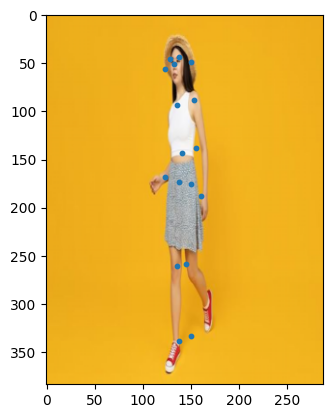

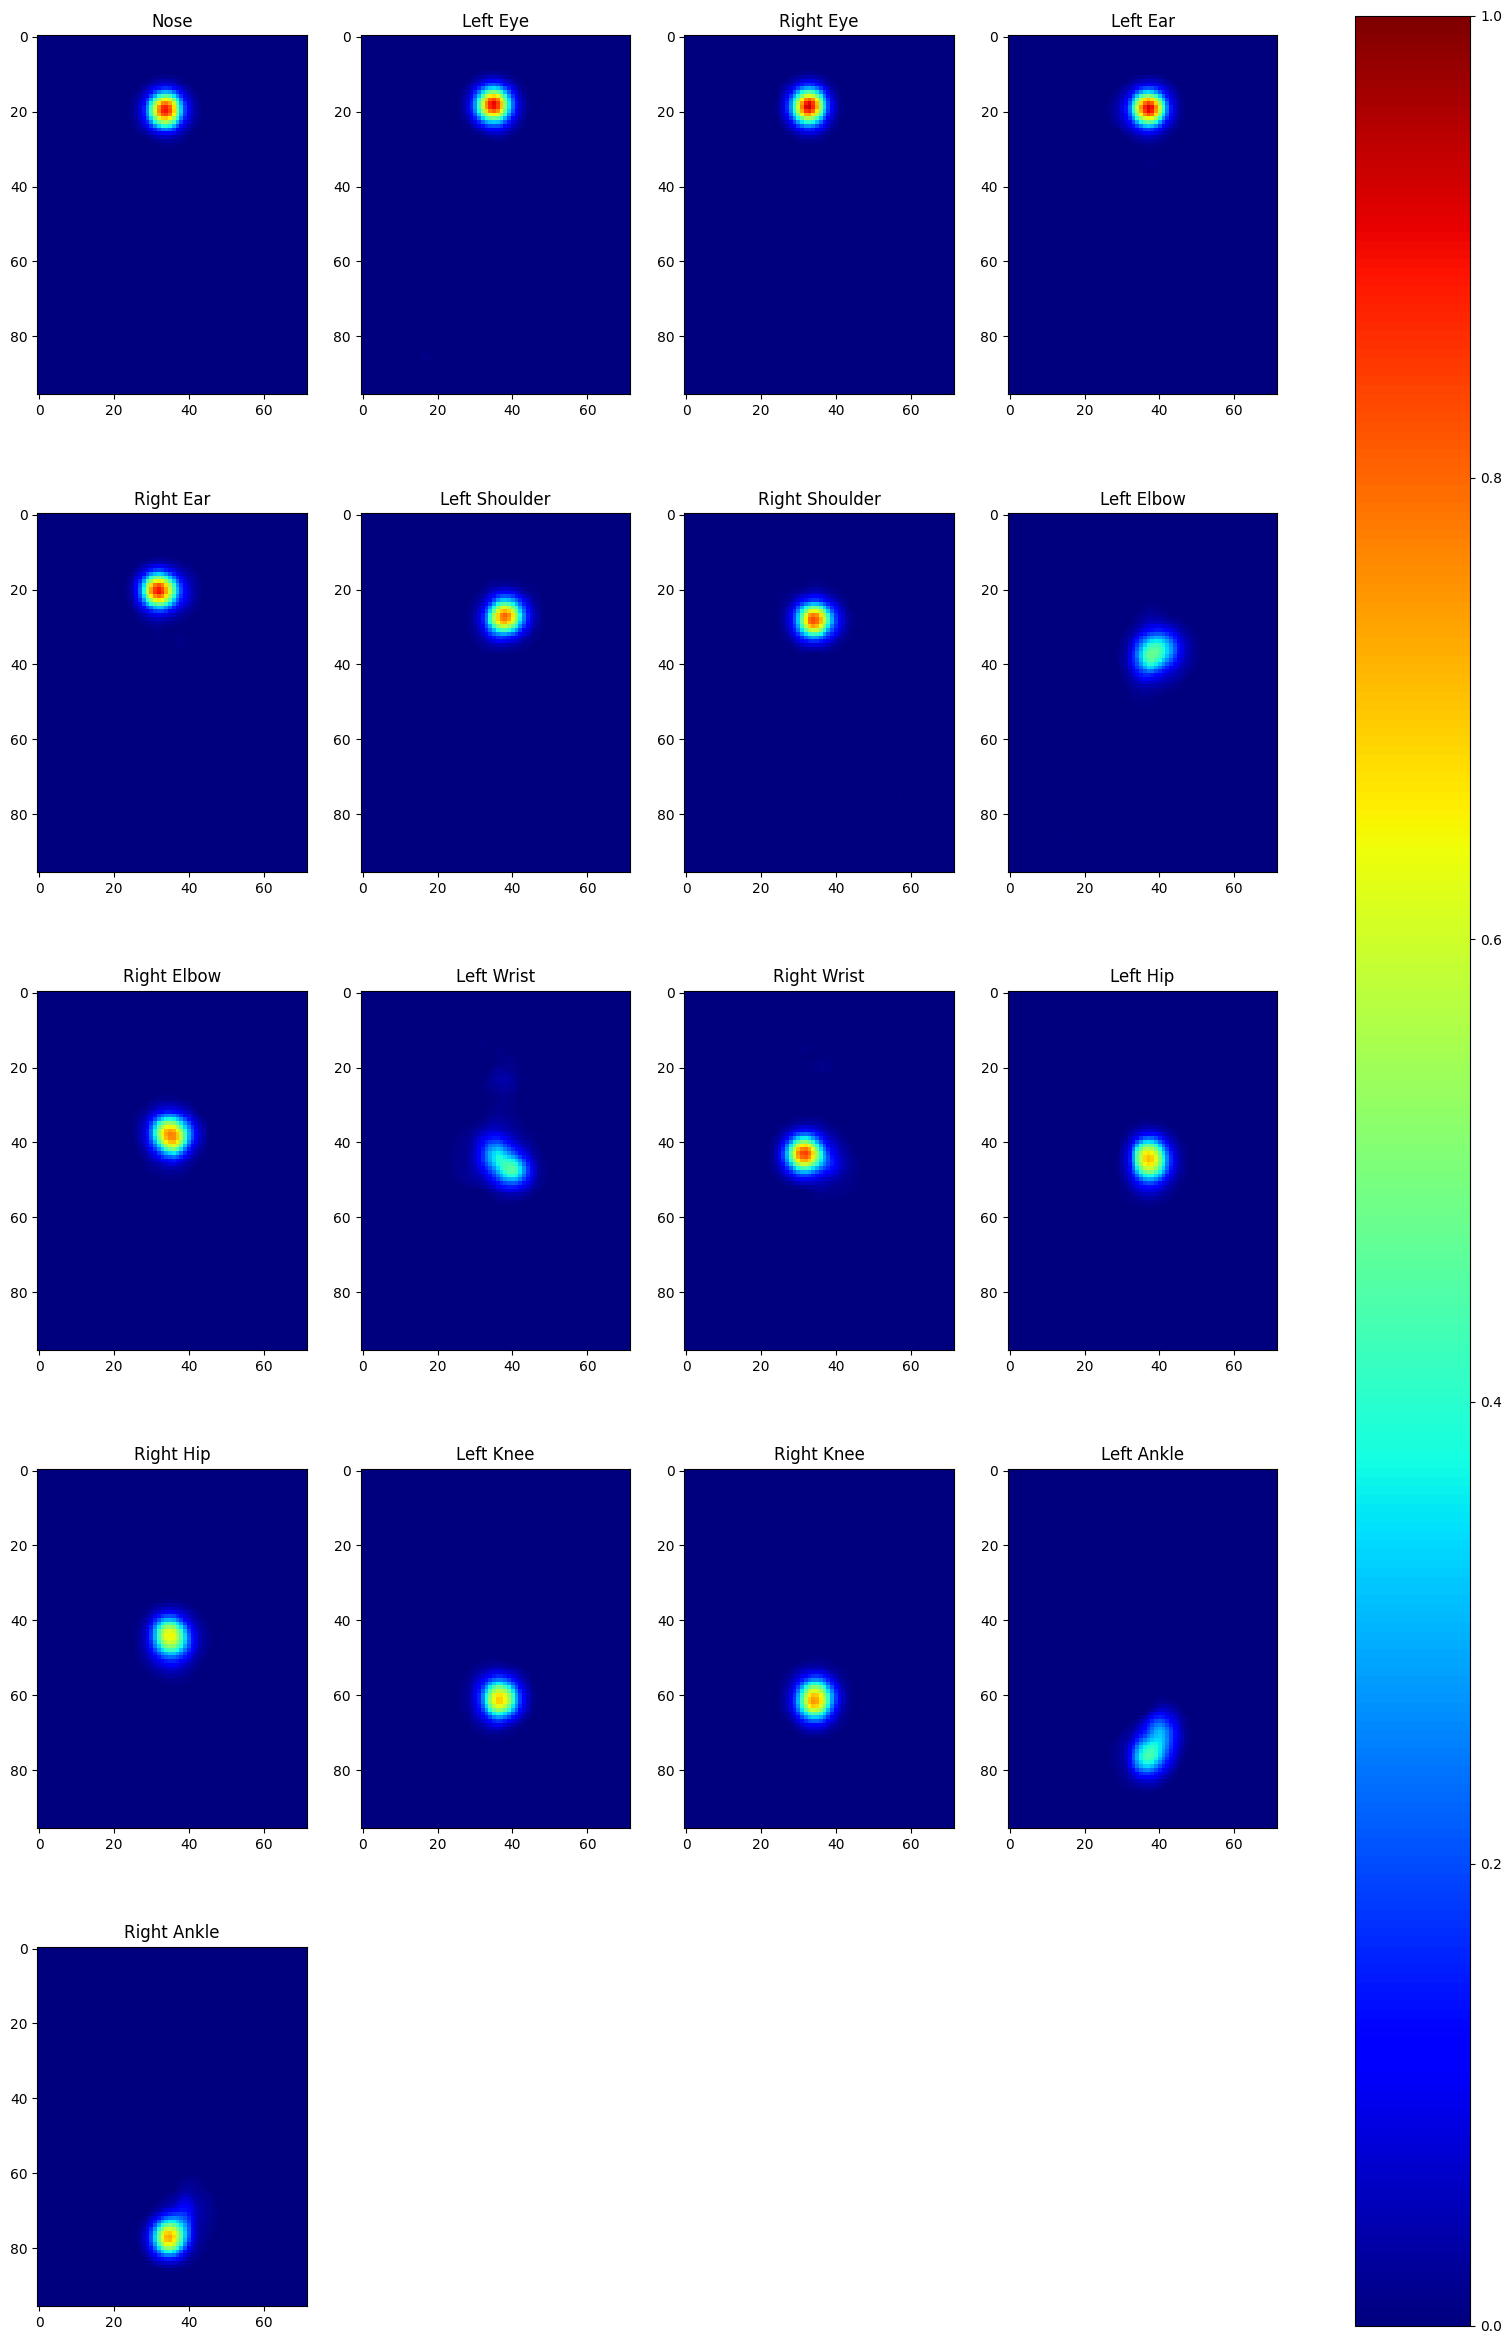

In [64]:
visualize_keypoints_and_heatmap(
    input_img_resized_bchw, keypoints=keypoints, heatmaps=heatmap)

In [3]:
torchvision.io.read_image('sample_img.jpg').type(torch.float32)

tensor([[[196., 196., 196.,  ..., 207., 205., 203.],
         [196., 196., 197.,  ..., 207., 207., 203.],
         [196., 197., 197.,  ..., 208., 207., 204.],
         ...,
         [214., 214., 214.,  ..., 224., 224., 224.],
         [213., 213., 213.,  ..., 223., 223., 223.],
         [213., 213., 213.,  ..., 223., 223., 223.]],

        [[197., 197., 197.,  ..., 207., 208., 206.],
         [197., 197., 198.,  ..., 207., 207., 206.],
         [197., 198., 198.,  ..., 208., 207., 207.],
         ...,
         [214., 215., 214.,  ..., 225., 225., 225.],
         [213., 213., 213.,  ..., 224., 224., 223.],
         [213., 213., 213.,  ..., 224., 224., 223.]],

        [[202., 202., 202.,  ..., 217., 217., 215.],
         [202., 202., 203.,  ..., 217., 217., 215.],
         [202., 203., 203.,  ..., 218., 217., 216.],
         ...,
         [222., 220., 222.,  ..., 230., 230., 230.],
         [223., 221., 223.,  ..., 229., 229., 231.],
         [223., 223., 223.,  ..., 229., 229., 233.]]]

In [8]:
from PIL import Image
import torchvision.transforms as transforms

In [15]:
image = Image.open('sample_img.jpg')
transform = transforms.PILToTensor()
tensor_image = transform(image)
tensor_image.shape

torch.Size([3, 626, 417])

In [16]:
type(image)

PIL.JpegImagePlugin.JpegImageFile

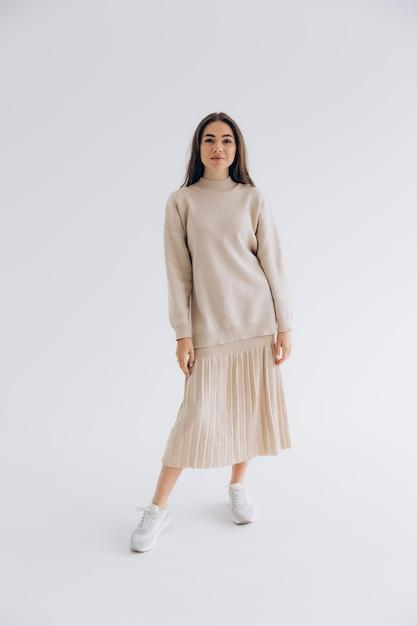

In [11]:
image.convert('RGB')